In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, models, callbacks

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split as tts

import matplotlib.pyplot as plt


from tqdm import tqdm

In [3]:
df_raw = pd.read_csv('DATA/filtered_train_data.csv')
df_raw

,date,nuser_id,norder_id,product_id,category,ncategory,quantity
0,2019-10-16 13:07:59,17943,0,1923615,نوشابه,50,5
1,2019-10-16 13:08:30,4480,1,847929,زعفران، زرشک و تزئینات غذا,21,2
2,2019-10-16 13:08:30,4480,1,1754809,تن ماهی,7,1
3,2019-10-16 13:08:30,4480,1,490777,شکلات صبحانه,28,1
4,2019-10-16 13:08:30,4480,1,490637,شکلات، تافی و آبنبات,29,1
...,...,...,...,...,...,...,...
1487204,2020-05-12 09:01:52,18137,374806,464179,پفک و اسنک,53,3
1487205,2020-05-12 09:01:52,18137,374806,761587,چیپس و پاپ کورن,57,1
1487206,2020-05-12 09:01:52,18137,374806,460100,چیپس و پاپ کورن,57,1
1487207,2020-05-12 09:01:52,18137,374806,490671,شکلات، تافی و آبنبات,29,1


In [4]:
df_out = pd.read_csv('DATA/filtered_sample_output.csv')
df_out

,nuser_id,0,1,2,3,4,5,6,7,8,...,56,57,58,59,60,61,62,63,64,65
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156068,156068,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156069,156069,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156070,156070,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156071,156071,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def get_temporal_data(raw, use_bin = False, tempo = 'month'):
    raw.index = pd.to_datetime(raw.date, format='%Y-%m-%d %H:%M:%S')
    raw.index = raw.index - pd.to_timedelta(12, unit='d')
    
    raw = raw.drop(['norder_id', 'product_id', 'category', 'date'], axis = 1)
    if use_bin:
        raw = raw.drop(['quantity'], axis = 1)
    
    if tempo == 'month':
        raw['t'] = raw.index.month + (raw.index.year - raw.index.year.min())*12
        raw['t'] = raw['t'] - raw['t'].min()
        tt = 7
    elif tempo == 'week':
        raw['t'] = raw.index.day_of_year + (raw.index.year - raw.index.year.min())*365
        raw['t'] = (raw['t'] - raw['t'].min())//7
        tt = 210//7
    elif tempo == 'day':
        raw['t'] = raw.index.day_of_year + (raw.index.year - raw.index.year.min())*365
        raw['t'] = (raw['t'] - raw['t'].min())
        tt = 210
     
    grouped = raw.groupby('nuser_id')
    
    uid = raw.nuser_id.unique()
    uid.sort()
    
    quantity = []
    for i in tqdm(uid):
        g = grouped.get_group(i)
        temporal = np.zeros((tt, 66))
        for _,j,k,l in g.values:
            temporal[l, j] += k
        quantity.append(temporal)
        
    return uid, np.asarray(quantity)
    

In [6]:
uid, data = get_temporal_data(df_raw, tempo = 'day', use_bin=False)


100%|████████████████████████████████████████████████████████████████████████| 156073/156073 [00:45<00:00, 3427.24it/s]


In [7]:
data.shape

(156073, 210, 66)

# Models

## GRU + Customer Embedding

In [9]:
window = 8
xs = []
ys = []
for i in range(15-window):
    x = data[:,i:i+window]
    y = (data[:,i+window:i+window+8].sum(axis=1)>0).astype('float')
    xs.append(x)
    ys.append(y)
    

In [10]:
len(xs)

7

In [11]:
ids = np.expand_dims(np.tile(uid, len(xs)), axis=1)
xs = np.concatenate(xs, axis=0)
ys = np.concatenate(ys, axis=0)


In [17]:
x_val = data[:,14:22]
y_val = (data[:,22:].sum(axis=1)>0).astype('float')
ids_val = uid
y_val.shape

(156073, 66)

In [18]:
tf.keras.backend.clear_session()
input_ids = tf.keras.Input((1,))
input_bin = tf.keras.Input((window, 66))

emb = layers.Embedding(input_dim=len(uid), output_dim=16, input_length=66)(input_ids)
emb = layers.Flatten()(emb)

out = layers.GRU(16, recurrent_regularizer=tf.keras.regularizers.L2(0.1))(input_bin, initial_state=emb)
out = layers.Dense(66)(out)

model = models.Model([input_bin, input_ids], out)



In [19]:
model.compile(
    optimizer=optimizers.Adam(), 
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=metrics.F1Score(average='micro')
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 16)                2497168   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 8, 66)]              0         []                            
                                                                                                  
 flatten (Flatten)           (None, 16)                   0         ['embedding[0][0]']           
                                                                                              

In [21]:
cb = [
    callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
model.fit([xs, ids], ys, validation_data=([x_val, ids_val], y_val), epochs=1)

I0000 00:00:1710647324.896445     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34141/34141 [==============================] - 156s 4ms/step - loss: 0.0771 - f1_score: 0.0769 - val_loss: 0.2558 - val_f1_score: 0.0771


In [22]:
p_val = tf.nn.sigmoid(model.predict([x_val, ids_val]))

4878/4878 [==============================] - 10s 2ms/step


In [17]:
# model.evaluate([x_val, ids_val], y_val)

In [18]:
# (p_val.numpy()>0.05).astype('int').sum()

In [19]:
# for i in range(100):
#     i /= 100
#     print('='*100)
#     print(i)
#     print(f1_score(y_val, p_val>i, average='micro'))

In [24]:
p_gru = tf.nn.sigmoid(model.predict([data[:, -8:, :], uid]))

4878/4878 [==============================] - 9s 2ms/step


In [53]:
pp = (x_val.sum(axis=1)>0).astype('float') + (p_val.numpy()>0.2)>0

In [56]:
f1_score(y_val, pp, average='micro')

0.08845846049508307

# ==================

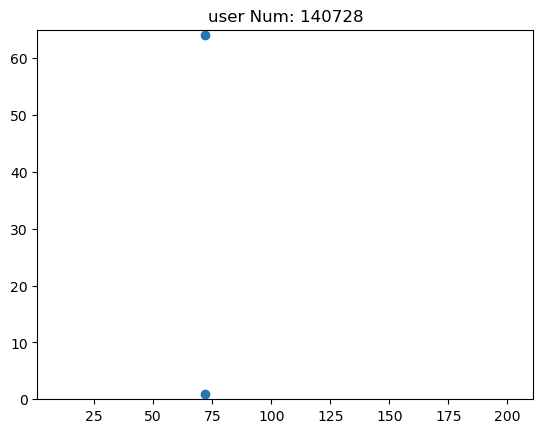

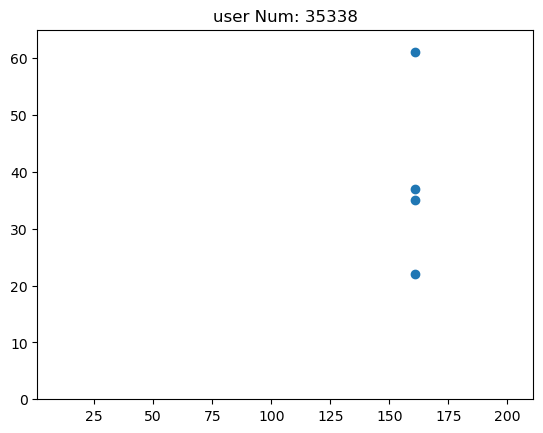

In [115]:
pool = np.random.choice(uid, size=2, replace=False)

for i in pool:
    a = (data[i]>0).nonzero()
    plt.scatter(a[0]+1, a[1])
    plt.title(f'user Num: {i}')
    plt.xlim([1, 211])
    plt.ylim([0, 65])
    plt.show()

In [32]:
data[0].shape

(210, 66)

# ========================

In [130]:
p = []
for a in tqdm(data):
    b1 = (a.sum(axis=1)>0).astype('int')
    b3 = a.sum()
    b2 = (a[-60:].sum(axis=1)>0).astype('int')
    b4 = (a[-120:].sum(axis=1)>0).astype('int')
    if b3<=3:
        a = np.zeros((66,))
#     elif b2.sum()<=1:
#         a = np.zeros((66,))
    elif b1.sum()>3 and b2.sum()>0:
        a = a[60:].sum(axis=0)
    else:
        a = a[-90:].sum(axis=0)
    
    p.append(a>0)
    
p = np.asarray(p, dtype='int')

100%|███████████████████████████████████████████████████████████████████████| 156073/156073 [00:09<00:00, 15697.30it/s]


In [131]:
p.sum()

622847

In [132]:
df_out.shape

(156073, 67)

In [133]:
df_out.values[:,1:] = p
df_out.to_csv('result.csv')

In [137]:
data.reshape(-1,66)[]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])